In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import xarray as xr
import cmocean.cm as cmo
import xgcm
import gsw
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
plt.rcParams['font.size']=14


In [2]:
def fix_dimension(ds, bad_dim, new_dim, trim=True):
    assert len(ds[bad_dim]) == (len(ds[new_dim]) + 1)
    if trim and (len(ds[bad_dim]) == (len(ds[new_dim]) + 1)):
        ds = ds.isel(**{bad_dim: slice(0,-1)})
        assert len(ds[bad_dim]) == len(ds[new_dim])
    swapped_vars = []
    for v in ds:
        # replace naughty dimension
        dims = list(ds[v].dims)
        if bad_dim in dims:
            idx = dims.index(bad_dim)
            dims[idx] = new_dim
            ds[v].variable.dims = dims
            swapped_vars.append(v)
    return ds, swapped_vars

def reset_dimensions(ds, orig_dim, new_dim, *reset_vars):
    for v in reset_vars:
        dims = list(ds[v].dims)
        if new_dim in dims:
            idx = dims.index(new_dim)
            dims[idx] = orig_dim
            ds[v].variable.dims = dims
    # reindexing necessary to figure out new dims
    return ds.reindex()

def open_mncdataset(fname_base, ntiles_y, ntiles_x, iternum=None):
    if iternum is not None:
        itersuf = '.%010d' % iternum
    else:
        itersuf = ''
    dsets_y = []
    for ny in range(ntiles_y):
        dsets_x = []
        swap_vars = set()
        for nx in range(ntiles_x):
            ntile = nx + ntiles_x*ny + 1
            fname = fname_base + '%s.t%03d.nc' % (itersuf, ntile)
            ds = xr.open_dataset(fname)
            ds, swapped_vars_x = fix_dimension(ds, 'Xp1', 'X')    
            ds = ds.chunk()
            dsets_x.append(ds)
        ds_xconcat = xr.concat(dsets_x, 'X')
        ds_xconcat, swapped_vars_y = fix_dimension(ds_xconcat, 'Yp1', 'Y')
        dsets_y.append(ds_xconcat)
    ds = xr.concat(dsets_y, 'Y')
    ds = reset_dimensions(ds, 'Xp1', 'X', *swapped_vars_x)
    ds = reset_dimensions(ds, 'Yp1', 'Y', *swapped_vars_y)
    return ds


In [3]:
# load model data

In [4]:
dsg = open_mncdataset('/media/disk3/birte/MITgcm_hr_20l/grid', 10, 15, None)
dss = open_mncdataset('/media/disk3/birte/MITgcm_hr_20l/state', 10,15, 0)
ds=xr.merge((dss,dsg))
ds=ds.isel(Zp1=slice(0,-1))
ds['Z']=-1*ds.Z
ds['Zl']=-1*ds.Zl
#ds=ds.rename_dims({'Xp1':'X_left','Yp1':'Y_left','Zp1':'Z_left'})
ds = xgcm.generate_grid_ds(ds, {'X':'X', 'Y':'Y', 'Z':'Z'})
ds.coords['day']=ds.T/(24*3600)
ds.coords['month']=ds.day/30

In [5]:
ds['drU']=ds.U.isel(T=0)*0+ds.drF.isel(X=30,Y=20)
ds['drV']=ds.V.isel(T=0)*0+ds.drF.isel(X=30,Y=20)
metrics = {
    ('X',): ['dxC', 'dxG', 'dxV'], # X distances
    ('Y',): ['dyC', 'dyG', 'dyU'], # Y distances
    ('Z',): ['drC', 'drF', 'drU' ,'drV'], # Z distances
    }
grid = xgcm.Grid(ds, periodic=False, metrics=metrics)

In [6]:
ds['U']=ds.U.swap_dims({"Xp1":"X_left"}) 
ds['V']=ds.V.swap_dims({"Yp1":"Y_left"}) 
ds['dyU']=ds.dyU.swap_dims({"Xp1":"X_left","Yp1":"Y_left"}) 
ds['dxV']=ds.dxV.swap_dims({"Xp1":"X_left","Yp1":"Y_left"}) 
ds['dxG']=ds.dxG.swap_dims({"Yp1":"Y_left"}) 
ds['dyG']=ds.dyG.swap_dims({"Xp1":"X_left"}) 
ds['dyC']=ds.dyC.swap_dims({"Yp1":"Y_left"}) 
ds['dxC']=ds.dxC.swap_dims({"Xp1":"X_left"}) 

ds['XG']=ds.XG.swap_dims({"Xp1":"X_left","Yp1":"Y_left"}) 
ds['YG']=ds.YG.swap_dims({"Xp1":"X_left","Yp1":"Y_left"}) 
ds['drV']=ds.drV.swap_dims({"Yp1":"Y_left"}) 
ds['drU']=ds.drU.swap_dims({"Xp1":"X_left"})
ds['HFacW']= ds.HFacW.swap_dims({"Xp1":"X_left"})
ds['HFacS']= ds.HFacS.swap_dims({"Yp1":"Y_left"})
ds['rAz']=ds.rAz.swap_dims({"Xp1":"X_left","Yp1":"Y_left"}) 

# reduce dataset to last time step  for computation speed

In [7]:
ds0=ds.isel(T=slice(0,1))
ds0
ds1=ds.isel(T=slice(-1,None,None))
ds1
ds1=xr.merge((ds0,ds1))
grid1 = xgcm.Grid(ds1, periodic=False, metrics=metrics)

/opt/tljh/user/lib/python3.9/site-packages/dask/array/core.py:4601: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
/opt/tljh/user/lib/python3.9/site-packages/dask/array/core.py:4601: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
/opt/tljh/user/lib/python3.9/site-packages/dask/array/core.py:4601: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
/opt/tljh/user/lib/python3.9/site-packages/dask/array/core.py:4601: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
/opt/tljh/user/lib/python3.9/site-packages/dask/array/core.py:4601: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
/opt/tljh/user/lib/python3.9/site-packages/dask/array/core.py:4601: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
/opt/tljh/user/lib/python3.9/site-packages/dask/array/core.py:4601: Performa

In [9]:
ds1['U_baro'] = (ds1.U* ds1.HFacW *ds1.drU).sum(dim='Z')
ds1['V_baro'] = (ds1.V* ds1.HFacS *ds1.drV).sum(dim='Z')

In [12]:
ds1['zeta_bt']= (-grid1.diff(ds1.U_baro * ds1.dxC, 'Y') + grid1.diff(ds1.V_baro * ds1.dyC, 'X'))/ds1.rAz
ds1.zeta_bt.load()

<xarray.DataArray 'zeta_bt' (T: 2, Y_left: 200, X_left: 300)>
array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 1.15882107e-01,  1.15882107e-01,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  1.15882107e-01],
        [ 6.48200512e-09,  6.48200512e-09,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  6.48200512e-09],
        ...,
        [ 7.22706318e-09,  7.22706318e-09,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  7.22706318e-09],
        [ 7.00354576e-09,  7.00354576e-09,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  7.00354576e-09],
        [-1.15883477e-01, -1.15883477e-01,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00, -1.15883477e-01]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 1.15882107e-01,  1.15882107e-01,  7.67830729e-02, ...,
          5.52081700e-02,  8.06930000e-02,  1.15882107e-01],
        [ 6.48200512e-09, -3.90990276e-02,  4.91137297e-02, ...,
          5.60400909e-02,  4.31713933e-02, -3.51891005e-02],
        ...,
        [ 7.22706318e-09,  3.98462892e-02, -6.30050592e-03, ...,
         -2.66062858e-02, -5.93840392e-03,  3.88671977e-02],
        [ 7.00354576e-09,  3.67223234e-02, -4.45668697e-02, ...,
         -5.98738305e-02, -4.74837497e-02,  3.74981731e-02],
        [-1.15883477e-01, -1.15883477e-01, -7.91611606e-02, ...,
         -5.22417606e-02, -7.83853113e-02, -1.15883477e-01]]])
Coordinates:
  * T        (T) float64 0.0 3.154e+08
  * X_left   (X_left) float64 0.0 5e+03 1e+04 ... 1.485e+06 1.49e+06 1.495e+06
  * Y_left   (Y_left) float64 0.0 5e+03 1e+04 ... 9.85e+05 9.9e+05 9.95e+05
    day      (T) float64 0.0 3.65e+03
    month    (T) float64 0.0 121.7

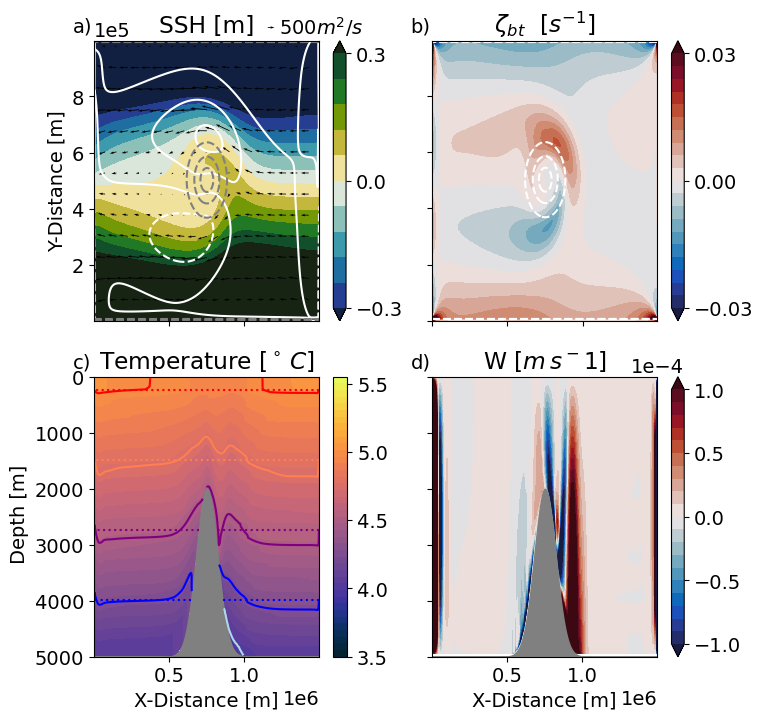

In [14]:

cbformat = matplotlib.ticker.ScalarFormatter()   # create the formatter
cbformat.set_powerlimits((-2,2))   
t=-1
arr=15
wmin=-.3
wmax=-1*wmin
cmap2=cmo.delta
lev=11
levl=np.linspace(wmin,wmax,7)
fig,axes=plt.subplots(2,2,figsize=(8,8))
ax=axes[0,0]
(ds1.Eta.isel(T=t)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':'','ticks':np.linspace(-.3,.3,3)})
(ds1.Eta.isel(T=t)-ds1.Eta.isel(T=t,X=slice(250,299)).mean(dim='X')).plot.contour(levels=levl,ax=ax,colors='w')
ds1.Depth.plot.contour(levels=[2500,3500,4500],ax=ax,linestyles='--',colors='gray')
q=ax.quiver(ds1.X[0:-1:arr],ds1.Y[0:-1:arr],grid.interp(ds1.isel(T=t).U_baro,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(ds1.isel(T=t).V_baro,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,1.05,500,label='$500m^2/s$',color='k',labelpos='E',labelcolor='k',labelsep=0.05)
ax.set_title(f'SSH [m]')
ax.set_ylabel('Y-Distance [m]')
ax.set_xlabel('')
ax.set_xticklabels('')
ax.ticklabel_format(axis='y', style='scientific', scilimits=[-4,4])
ax.text(-0.05, 1.05, 'a)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

wmin=-.03
wmax=-1*wmin
cmap2=cmo.balance
lev=21
ax=axes[0,1]

ds1.zeta_bt.isel(T=-1).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':'','ticks':np.linspace(-.03,.03,3)})
ds1.Depth.plot.contour(levels=[2500,3500,4500],ax=ax,linestyles='--',colors='w')
ax.set_title('$\\zeta_{bt}$  [$s^{-1}$]')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels('')
ax.set_yticklabels('')
#ax.ticklabel_format(axis='y', style='scientific', scilimits=[-4,4])
ax.text(-0.05, 1.05, 'b)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)



tmin1=3.5
tmax1=5.55
cmapt1=cmo.thermal
levt1=43
#plot Wsection  for 20 layer cases
wmin=-0.0001
wmax=0.0001
cmap2=cmo.balance
lev=21
#-----------------
ax = axes[1,0]
cbt1=(ds1.Temp.where(ds1.Temp>0).isel(T=t,Y=100)).plot.contourf(cmap=cmapt1,vmin=tmin1,vmax=tmax1,levels=levt1,ax=ax,cbar_kwargs={'label':'','ticks':np.linspace(3.5,5.5,5)})
cctt1=ds1.Temp.where(ds1.Temp>0).isel(T=t,Y=100).plot.contour(ax=ax,colors=['lightblue','b','purple','coral','r','yellow'],levels=[4.0,4.25,4.5,4.75,5,5.25])
ds1.Temp.where(ds1.Temp>0).isel(T=0,Y=100).plot.contour(ax=ax,colors=['lightblue','b','purple','coral','r','yellow'],levels=[4.0,4.25,4.5,4.75,5,5.25],linestyles=':')
ax.fill_between(ds1.X,(ds1.Depth).isel(Y=100),5000,color='grey')
ax.set_title(f'Temperature [$^\circ\,C$]')
ax.set_xlabel('X-Distance [m]')

ax.set_ylabel(' Depth [m]')
ax.set_ylim((5000,0))

ax.text(-0.05, 1.05, 'c)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

ax =  axes[1,1]
cb=(ds1.W.isel(T=t,Y=100)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':'','ticks':np.linspace(-1e-4,1e-4,5),'format':cbformat})

ax.fill_between(ds1.X,(ds1.Depth).isel(Y=100),5000,color='grey')
ax.set_title(f'W [$m\,s^{-1}$]')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('')

ax.set_yticklabels('')
ax.set_ylim((5000,0))

ax.text(-0.05, 1.05, 'd)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)


plt.savefig('./CaseC2_hr_sum.jpg')